# Brazilian or European Portuguese?

This simple classifier verifies which Portuguese norm prevails in a given text.

We start by defining the problem - what question do we want to answer?<br>
In this case - is the text written in <a href="https://en.wikipedia.org/wiki/Portuguese_dialects">European or Brazilian Portuguese</a>?

In order to do it, I:
- gather data 
- prepare them for the ML algorithm
- train it and verify its accuracy
- export the trained algorithm to use it in the future.


# Gathering data

That is - what data do I need, where to gather them and how. In this case I chose TED.com as my source of data. It's a reasonably large database of lectures with a clear division between both Portuguese dialects. I scraped the lecture transcriptions using a Scrapy spider. The code for the two spiders is <a href="https://github.com/MarekCichy/pt-br-classifier/blob/master/PTCrawler.py">here</a> and <a href="https://github.com/MarekCichy/pt-br-classifier/blob/master/BRCrawler.py">here</a>.

# Data wrangling

I scraped about 2500 TED talks for each version of Portuguese, some 12-18 thousand characters per talk. After cleaning formatting (leaving only pure text), I mark the transcriptions "0" for PT-PT (European Portuguese) and "1" for PT-BR, then transform it with scikit-learn's CountVectorizer. 

CountVectorizer basically counts the number of occurences of all the words in each document. I do not use any other preprocessing. I do not stem the words, as I want to maintain the grammatical differences (e.g. verb conjugation differences) between both dialects.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics

from nltk import sent_tokenize

from joblib import dump, load

In [2]:
#importing scraped texts
pt_talks = pd.read_excel('talks_pt.xlsx').dropna()
br_talks = pd.read_excel('talks_br.xlsx').dropna()

In [3]:
pt_talks.head()

,0
Lindy Lou Isonhood,"\n\t\t\t\t\t\t\t\t\t\t\tFoi numa quarta-feira,..."
Jonathan Wilker,\n\t\t\t\t\t\t\t\t\t\t\tGostava que viessem co...
Michael C. Bush,"\n\t\t\t\t\t\t\t\t\t\t\tInterrogamos CEOs, pol..."
Rene Laufer,\n\t\t\t\t\t\t\t\t\t\t\tA mais de seis mil ano...
Kym Worthy,"\n\t\t\t\t\t\t\t\t\t\t\tEm Agosto de 2009, a m..."


In [4]:
pt_talks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2409 entries, Lindy Lou Isonhood to Stefana Broadbent
Data columns (total 1 columns):
0    2409 non-null object
dtypes: object(1)
memory usage: 37.6+ KB


In [5]:
#cleaning up
pt_talks.columns = ['text']
pt_talks.text = pt_talks.text.apply(lambda x:x.replace('\n',' '))
pt_talks.text = pt_talks.text.apply(lambda x:x.replace('\t',' '))
pt_talks['label'] = 0
pt_talks.head()

,text,label
Lindy Lou Isonhood,"Foi numa quarta-feira, ...",0
Jonathan Wilker,Gostava que viessem comigo numa vi...,0
Michael C. Bush,"Interrogamos CEOs, polícias, camio...",0
Rene Laufer,A mais de seis mil anos-luz ...,0
Kym Worthy,"Em Agosto de 2009, a minha procura...",0


In [6]:
br_talks.columns = ['text']
br_talks.text = br_talks.text.apply(lambda x:x.replace('\t',' '))
br_talks.text = br_talks.text.apply(lambda x:x.replace('\n',' '))
br_talks['label'] = 1
br_talks.head()

,text,label
Stacie Bosley,"Em 2004, uma nova empre...",1
César Hidalgo,Sou só eu ou há outras ...,1
Sarah Barmak,"Em nossa cultura, tendemos a ver o...",1
Shohini Ghose,Se quisesse dar apenas uma olhadin...,1
Balsher Singh Sidhu,"Olhando do espaço, nosso planeta p...",1


In [7]:
br_talks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2897 entries, Stacie Bosley to José Antonio Abreu
Data columns (total 2 columns):
text     2897 non-null object
label    2897 non-null int64
dtypes: int64(1), object(1)
memory usage: 67.9+ KB


In [8]:
#making a joint DF
joint_df = pd.concat([br_talks, pt_talks])
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5306 entries, Stacie Bosley to Stefana Broadbent
Data columns (total 2 columns):
text     5306 non-null object
label    5306 non-null int64
dtypes: int64(1), object(1)
memory usage: 124.4+ KB


In [9]:
joint_df.head()

,text,label
Stacie Bosley,"Em 2004, uma nova empre...",1
César Hidalgo,Sou só eu ou há outras ...,1
Sarah Barmak,"Em nossa cultura, tendemos a ver o...",1
Shohini Ghose,Se quisesse dar apenas uma olhadin...,1
Balsher Singh Sidhu,"Olhando do espaço, nosso planeta p...",1


In [10]:
joint_df.label.value_counts()

1    2897
0    2409
Name: label, dtype: int64

In [11]:
vectorizer = CountVectorizer(min_df=2)

In [12]:
y = joint_df.label
X_train, X_test, y_train, y_test = train_test_split(joint_df['text'], y, test_size=0.33, random_state=53)
X_train.head(10)

Thomas Dolby                      Eu tenho vindo a tocar no TED há q...
Mike Gil                          Quem aqui é fascinado pela vida no...
Shimon Steinberg                  Sou um amante de insetos,         ...
Chiki Sarkar                      Olhem ao seu redor.            Sej...
Elizabeth Lev                     Imaginem que estão em Roma        ...
Rachel Pike                       Quero falar a vocês hoje sobre a m...
Tiana Epps-johnson                Ok, eu quero tirar um momento para...
DeAndrea Salvador                 Quando eu criança,            pass...
Stefano Mancuso                   As vezes folheio            revist...
Vinay Venkatraman                 Frugal Digital é basicamente um pe...
Name: text, dtype: object

In [13]:
y_train.describe()

count    3555.000000
mean        0.536428
std         0.498741
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [14]:
y_test.describe()

count    1751.000000
mean        0.565391
std         0.495847
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [15]:
train = vectorizer.fit_transform(X_train.values)

In [16]:
vectorizer.vocabulary_

{'eu': 23892,
 'tenho': 54360,
 'vindo': 57598,
 'tocar': 54918,
 'no': 39520,
 'ted': 54128,
 'há': 29681,
 'quase': 46240,
 'uma': 56460,
 'década': 19979,
 'raramente': 46764,
 'toquei': 55070,
 'músicas': 38800,
 'novas': 39705,
 'da': 15630,
 'minha': 37502,
 'autoria': 6774,
 'isso': 32894,
 'aconteceu': 1651,
 'em': 20550,
 'grande': 28194,
 'parte': 41585,
 'porque': 43853,
 'não': 39836,
 'havia': 28850,
 'nenhuma': 39234,
 'risos': 49645,
 'estado': 23300,
 'ocupado': 40188,
 'com': 12018,
 'alguns': 3101,
 'projetos': 45245,
 'um': 56459,
 'deles': 16317,
 'era': 22178,
 'este': 23391,
 'barco': 7391,
 'salva': 50442,
 'vida': 57483,
 'dos': 19674,
 'anos': 4063,
 '30': 488,
 'que': 46246,
 'andado': 3846,
 'restaurar': 49028,
 'jardim': 33031,
 'casa': 10057,
 'de': 15812,
 'praia': 44150,
 'inglaterra': 31421,
 'portanto': 43877,
 'agora': 2583,
 'quando': 46195,
 'as': 5635,
 'calotas': 9343,
 'polares': 43588,
 'meu': 37205,
 'estúdio': 23812,
 'gravação': 28262,
 'ergue

In [17]:
print(train[:10,23892])

  (0, 0)	7
  (1, 0)	3
  (2, 0)	2
  (3, 0)	17
  (4, 0)	1
  (5, 0)	4
  (6, 0)	7
  (7, 0)	5
  (8, 0)	2
  (9, 0)	8


In [18]:
X_train.iloc[:5]


Thomas Dolby                    Eu tenho vindo a tocar no TED há q...
Mike Gil                        Quem aqui é fascinado pela vida no...
Shimon Steinberg                Sou um amante de insetos,         ...
Chiki Sarkar                    Olhem ao seu redor.            Sej...
Elizabeth Lev                   Imaginem que estão em Roma        ...
Name: text, dtype: object

In [19]:
train

<3555x59061 sparse matrix of type '<class 'numpy.int64'>'
	with 2211580 stored elements in Compressed Sparse Row format>

# Training

Unsurprisingly, I split the texts into a training and testing sets and train a MultinomialNaiveBayes model on these. The model basically checks the frequency of a given word in the BR and PT sets and thus determines if the word suggests a more "Brazilian" or "Portuguese" word. All of the words in a phrase are weighed and the final probability is given.

I transform the test set - I want to be able to classify short texts, of, say, 4 sentences. Thus, I split the test set texts into smaller ones. Let's see how it reflects on the classifier's precision.

In [20]:
nb_classifier = MultinomialNB()
nb_classifier.fit(train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
test_tokenized = X_test.apply(lambda x: sent_tokenize(x))
spread = test_tokenized.apply(pd.Series)
spread = spread.fillna('')
for y in range(0,340,4):
    spread['grouped'+str(y/4)] = spread.iloc[:,y:y+4].apply(lambda x: ' '.join(x), axis=1)
spread = spread.loc[:,'grouped0.0':]
spread['label'] = y_test
test_df = spread.melt(id_vars='label')
test_df['len'] = test_df.value.apply(lambda x: len(x))
test_df = test_df[test_df.len > 30]

In [22]:
test = vectorizer.transform(test_df.value)

In [23]:
pred = nb_classifier.predict(test)
proba = nb_classifier.predict_proba(test)
score = metrics.accuracy_score(test_df.label, pred)
score

0.8654743849835536

In [24]:
cm = metrics.confusion_matrix(test_df.label, pred, labels = [0,1])
cm

array([[18393,  3450],
       [ 3380, 25548]], dtype=int64)

# Result

Not bad! A simple method and a dataset smaller than the whole Wikipedia gave 86,47% accuracy for short texts, 4 sentences long. These are, naturally, samples from the same source as the test set. In the future I want to check the classifier's performance in other genres.

For the time being, let's print out some incorrect classification examples.

In [25]:
proba_br = proba[:,1]
proba_br

array([8.67390449e-01, 9.99985685e-01, 9.99998752e-01, ...,
       9.04493681e-04, 9.99999825e-01, 4.64320545e-02])

In [26]:
check_falses = test_df.reset_index()
check_falses['pred'] = pred
check_falses['proba_br'] = proba_br

falses = check_falses[check_falses['label'] != check_falses['pred']]
falses.values[50:60]

array([[378, 1, 'grouped0.0',
        '            Nós vemos com os olhos. Mas também vemos com o cérebro. E ver com o cérebro é geralmente chamado de imaginação. E estamos familiarizados com os cenários de nossa própria imaginação,            nossos cenários internos.',
        230, 0, 0.19057855616759076],
       [386, 1, 'grouped0.0',
        '            Em março de 2017,            o prefeito da Cidade do Cabo declarou calamidade pública,            porque a cidade tinha menos de quatro meses de água potável. Cada habitante ficou restrito a 100 litros de água por dia. Mas o que significa isso na prática? Com 100 litros de água por dia, podemos tomar um banho de cinco minutos,            lavar o rosto duas vezes            e provavelmente dar descarga cerca de cinco vezes.',
        438, 0, 0.08104028835696907],
       [402, 1, 'grouped0.0',
        '            Como cientista e como ser humano,            tenho tentado tornar-me            sensível à maravilha. Acho que, na noite 

In [27]:
falses.describe(percentiles=[.05, .5, .95])

,index,label,len,pred,proba_br
count,6830.000000,6830.000000,6830.000000,6830.000000,6.830000e+03
mean,33214.630015,0.494876,358.703953,0.505124,5.069281e-01
std,25269.979102,0.500010,189.998301,0.500010,3.391841e-01
min,0.000000,0.000000,32.000000,0.000000,1.111707e-08
5%,2711.600000,0.000000,111.000000,0.000000,7.857553e-03
50%,27982.500000,0.000000,334.000000,1.000000,5.054829e-01
95%,83040.550000,1.000000,683.000000,1.000000,9.936389e-01
max,145241.000000,1.000000,5094.000000,1.000000,1.000000e+00


In [28]:
check_falses.describe(percentiles=[.05, .5, .95])

,index,label,len,pred,proba_br
count,50771.000000,50771.000000,50771.000000,50771.000000,5.077100e+04
mean,32809.481121,0.569774,409.724823,0.571153,5.680843e-01
std,24935.362826,0.495113,203.416989,0.494916,4.421417e-01
min,0.000000,0.000000,31.000000,0.000000,5.318441e-29
5%,2543.500000,0.000000,150.000000,0.000000,5.344424e-07
50%,27671.000000,1.000000,382.000000,1.000000,7.861301e-01
95%,81126.000000,1.000000,760.000000,1.000000,1.000000e+00
max,148356.000000,1.000000,10736.000000,1.000000,1.000000e+00


# Classifier comparison

How would logistic regression fare on the same problem? Were my tutors right in recommending NaiveBayes?

In [29]:
lr = LogisticRegression()
lr.fit(train, y_train)
lr.score(train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.99915611814346

In [30]:
lr.score(test, test_df.label)

0.7444998128853085

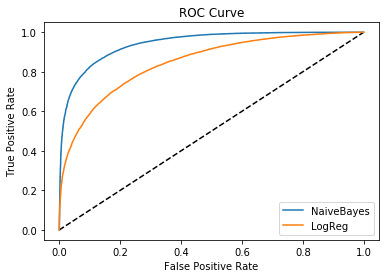

In [31]:
y_nb_pred_prob = nb_classifier.predict_proba(test)[:,1]
y_lr_pred_prob = lr.predict_proba(test)[:,1]

nb_fpr, nb_tpr, nb_thresholds = metrics.roc_curve(test_df.label, y_nb_pred_prob)
lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(test_df.label, y_lr_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(nb_fpr, nb_tpr, label='NaiveBayes')
plt.plot(lr_fpr, lr_tpr, label='LogReg')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right') 
plt.show()

# Export

The original method is clearly superior to logistic regression. 
In the last step, I export the data (word counts and NaiveBayes weights) into a JSON format and the model itself into a Joblib format in order to use it externally, e.g. on a <a href="http://marekcichy.alwaysdata.net">Web page</a>.

In [32]:
json_df = pd.DataFrame([vectorizer.inverse_transform(nb_classifier.coef_)[0], 
                        nb_classifier.feature_count_[0], nb_classifier.feature_count_[1], 
                        nb_classifier.feature_log_prob_[0], nb_classifier.feature_log_prob_[1]])

json_df = json_df.T

json_df.columns = ['word', 'pt_count', 'br_count', 'pt_log_prob', 'br_log_prob']
json_df = json_df.set_index('word')


In [33]:
json_df.loc['eu']

pt_count         14460
br_count         29596
pt_log_prob   -5.16163
br_log_prob   -4.63149
Name: eu, dtype: object

In [34]:
json_dict = json_df.to_dict()

In [35]:
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(json_dict, f, ensure_ascii=False, indent=4)

In [36]:
pipeline = Pipeline([('vectorizer',vectorizer),('classifier',nb_classifier)])

dump(pipeline, 'ptclassifier.joblib', protocol = 2) 

['ptclassifier.joblib']